# 基于神经网络的时间序列预测

本代码来自弗朗西斯卡所著《时间序列预测：基于机器学习和python实现》

In [2]:
import datetime as dt
import os
import warnings
from collections import UserDict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import Image
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# 两种绘图接口
import plotly_express as px
import plotly.graph_objects as go

%matplotlib inline

warnings.filterwarnings("ignore")
pd.options.display.float_format = "{:,.2f}".format
np.set_printoptions(precision=2)

## 将深度学习用作时间序列预测的原因

深度学习神经网络具有三个主要的内在特征：
- 深度学习神经网络能够自动从原始数据中学习和提取特征。
- 深度学习支持多个输入和输出。
- 循环神经网络擅长提取跨越相对较长序列的输入数据中的模式。

神经网络消除了对特征工程过程、数据缩放过程的大量迫切需求以及通过差分使数据保持稳定。

1、单变量时间序列是具有单个时间相关变量的序列。在单变量时间序列场景中，数据集将基于两个变量，即时间和历史观测值。  
2、多变量时间序列是具有多个与时间有关的变量。这样的序列属于多元时间序列。

将深度学习用于多步预测的主要方法有两种：
- 直接：开发单独的模型来预测每个的前置时间。
- 递归：开发一个模型来进行单步预测，并循环使用该模型，其中先前的预测用作输入以预测后续的前置时间。

## 基于循环神经网络的时间序列预测

### 循环神经网络

RNN是具有隐含状态和循环的神经网络，可以使信息随时间持续存在。

![hello](../images/p14.jpg)

RNN具有一个内部隐含状态，表示为$H$，可以将其反馈给网络。在此图中，RNN处理输入值$X$并产生输出值$Y$。隐含状态（表示为$H$）允许信息从网络的一个节点转发到下一个节点（按序列或向量组织）。向量现在具有与当前输入和先前输入有关的信息，通过$tanh$激活，输出为新的隐含状态。$tanh$激活用于调节通过网络的值，并且始终将值保持在-1和1之间。

$W$表示每个单元具有三组权重，一组用于输入（$X$），一组用于上一个时间步（$H$），剩余一组用于当前时间步的输出（$Y$）。这些权重值由训练过程确定，可以通过梯度下降来实现。

我们将相同的权重应用于输入序列中的不同项目，这意味着在输入时共享参数。如果不能在输入时共享参数，那么RNN就像普通的神经网络一样，每个输入节点都需要自己的权重。相反，RNN可以利用其隐含状态属性，该属性将当前输入绑定到下一个输入，并将此输入连接合并为串行输入。

![hello](../images/p15.jpg)

RNN问题
- 如果输入序列足够长，则其无法将信息从较早的时间步传递到较晚的时间步。
- 在反向传播期间，因为随着时间反向传播，其梯度会减小。因此循环神经网络会遇到梯度消失的问题，提出LSTM，在LSTM中引入了成为门和单元状态的其他元素。

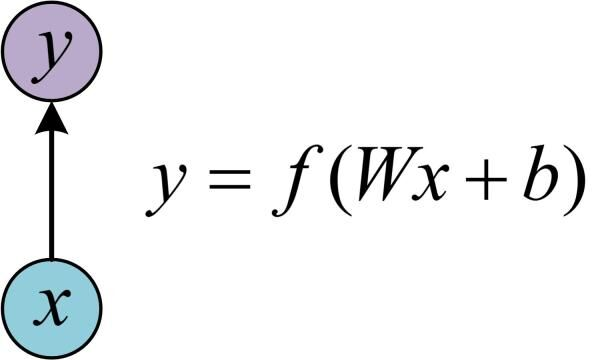
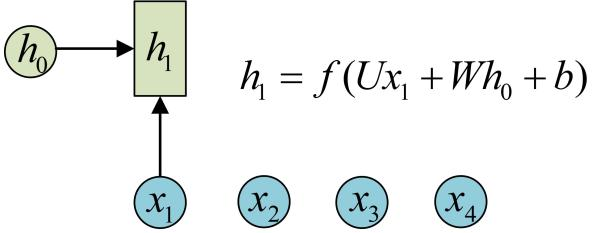
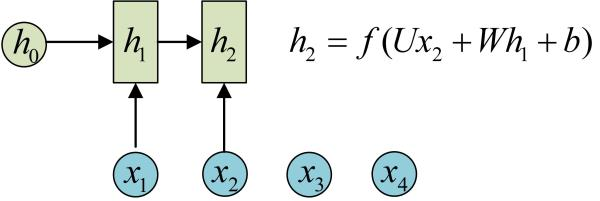
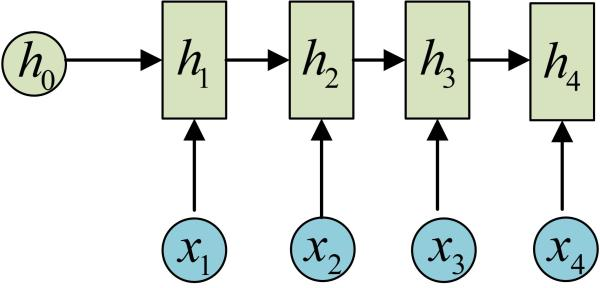
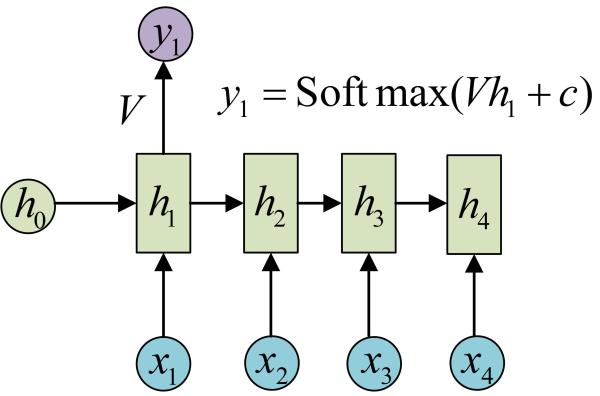
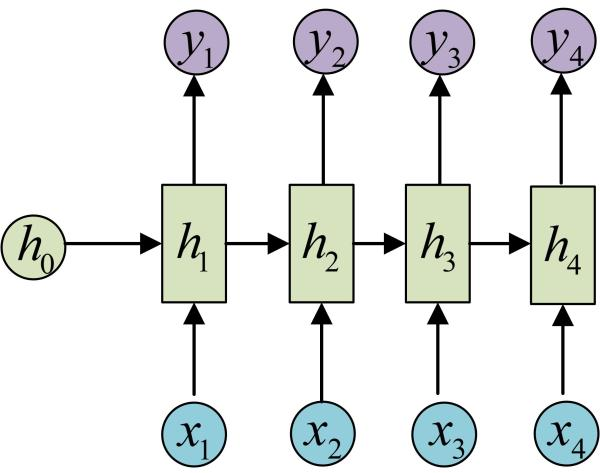

最经典的RNN结构，是$x1, x2, .....xn$，输出为$y1, y2, ...yn$，也就是说，输入和输出序列必须要是等长的。

### 长短期记忆

LSTM具有称为门和单元状态的内部机制，可以控制信息流。单元决定信息的选择、信息量以及存储和释放的时机：通过预测、反向传播误差和梯度下降调整权重的迭代过程来学习何时允许信息进入、离开和删除。

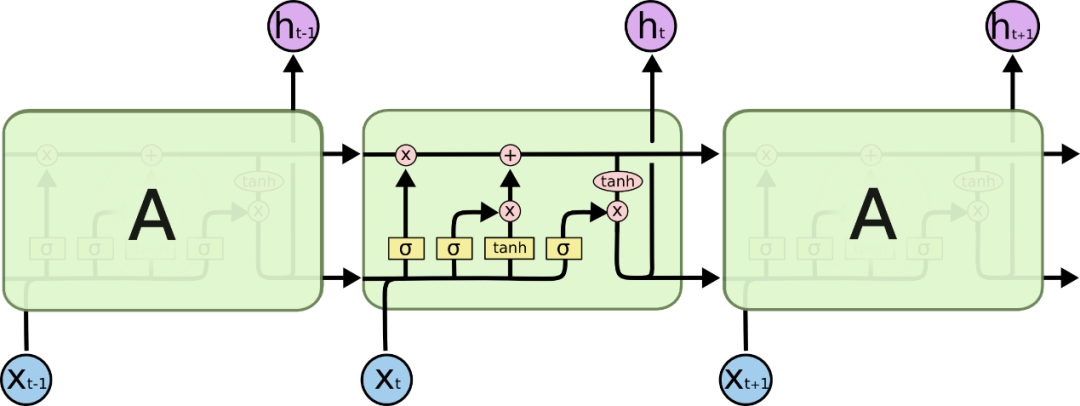

根据图示我们可以看到：LSTM主要有三个门组成，即遗忘门、输入门和输出门。

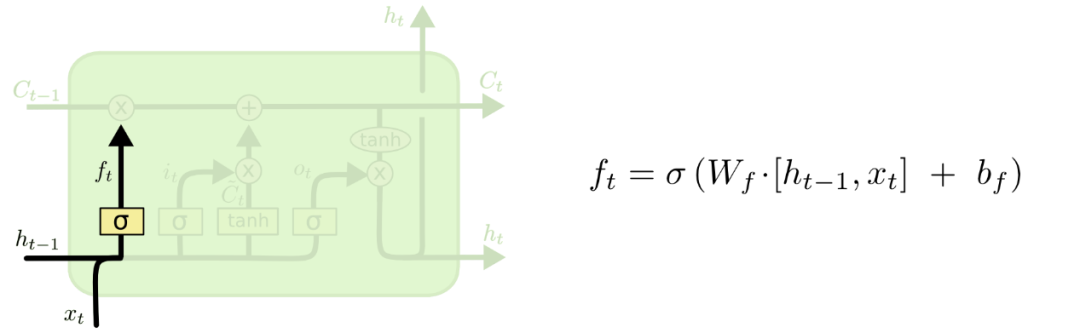

LSTM遗忘门会读取$h_{t-1}$和$x_t$，输出一个在0到1之间的数值，并传递给每个细胞状态$C_{t-1}$。1表示“完全保留”，0表示“完全舍弃”。

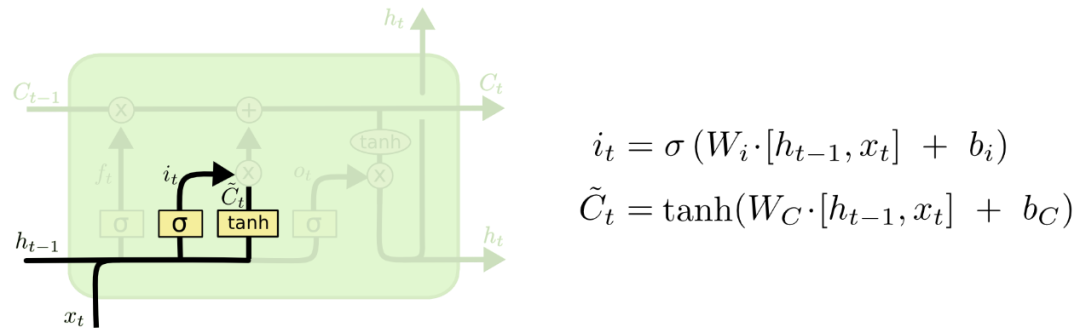

接下来，则由LSTM输入门确定什么样的新信息可以被存放在细胞状态中，这里包含两个部分：首先，sigmoid层决定什么值将要被更新；然后，tanh层创建一个新的候选值向量$\tilde{C_t}$，并在之后将$\tilde{C_t}$加入至状态中。

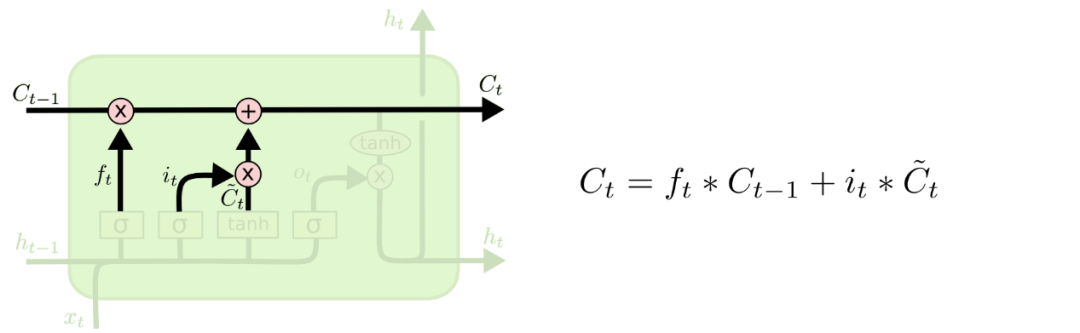

我们将旧状态与$f_t$相乘，丢弃掉确定需要丢弃的信息，并加上$i_t*\tilde{C_t}$，由此得到新的候选值。

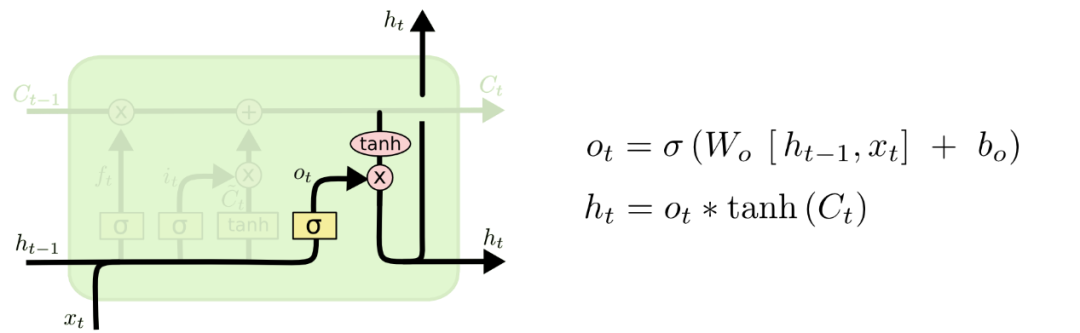

LSTM输出门将基于细胞状态形成一个过滤后的版本。首先，运行sigmoid层来确定细胞状态将要输出哪个部分；接着，通过tanh层处理细胞状态（得到一个在-1到1之间的值）并将它和sigmoid门的输出相乘，最终，LSTM输出门仅会输出我们确定需要的部分。

### 门控循环单元

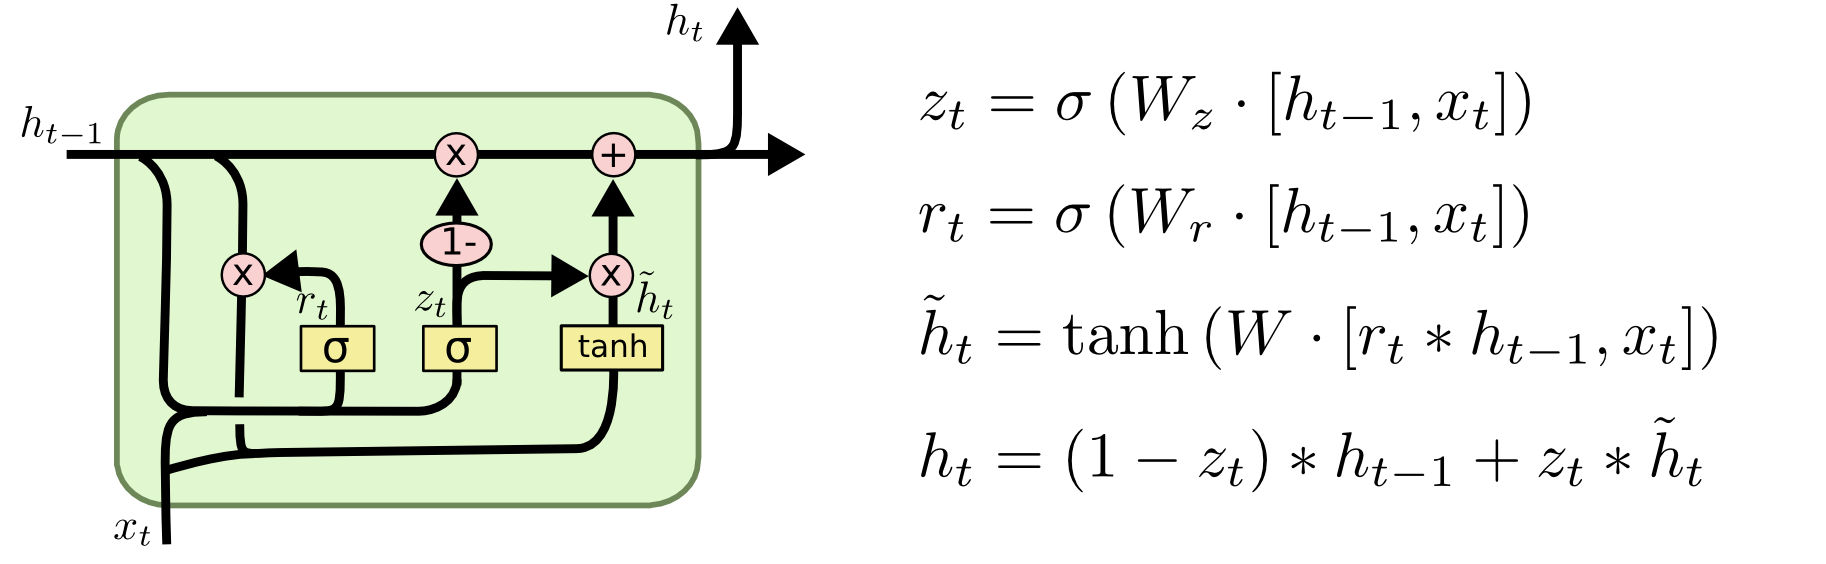

GRU将遗忘门和输入门合成了一个单一的更新门$z_t$。同样还混合了细胞状态和隐藏状态，和其他一些改动。最终的模型比标准的LSTM模型要简单，也是非常流行的变体。
- 更新门$z_t$：$z_{t}$是属于要记住的，反过来$1- z_{t}$则是属于忘记的，相当于对输入$h_{t-1}$、$x_{t}$做了一些更改/变化。
- 重置门$r_t$：相当于先见之明的把输入$h_{t-1}$、$x_{t}$在$z_{t}$/$1- z_{t}$对其做更改/变化之前，先事先存一份原始的。

### 数据要求

![hello](../images/p18.jpg)

样本数量、时间步和特征代表进行预测所需的条件（ 𝑋
 ），而样本和范围代表进行的预测（ 𝑌
 ）。如果以单变量时间序列问题为例，而我们对单步预测（例如，下一个小时）感兴趣，那么前一个时间步的观测值（例如，前四个小时的值，即滞后观测值）被用作输入，输出是下一个时间步的观测值。

重要步骤：
- 在训练集上训练模型。
- 然后，在每个训练时期之后，将验证集用于评估模型，并确保模型不会过度拟合训练模型。
- 模型完成训练后，在测试集中评估模型。
- 在处理时间序列数据时，重要的是要确保验证集和测试集都覆盖了来自训练集的之后时间段，以使模型不会从将来的时间戳信息中受益。

## 基于卷积神经网络的时间序列预测

一维卷积神经网络（1D CNN）通常用于处理时序数据，例如时间序列或信号数据。这种网络结构可以有效地捕获时序数据中的局部模式和趋势。

CNN属于前馈神经网络的一种，特点是每层的神经元节点只响应前一层局部区域范围内的神经元。一个深度卷积神经网络模型，一般由若干卷积层叠加若干全连接层组成，中间包含各种的卷积操作、池化操作。其结构图如下所示：

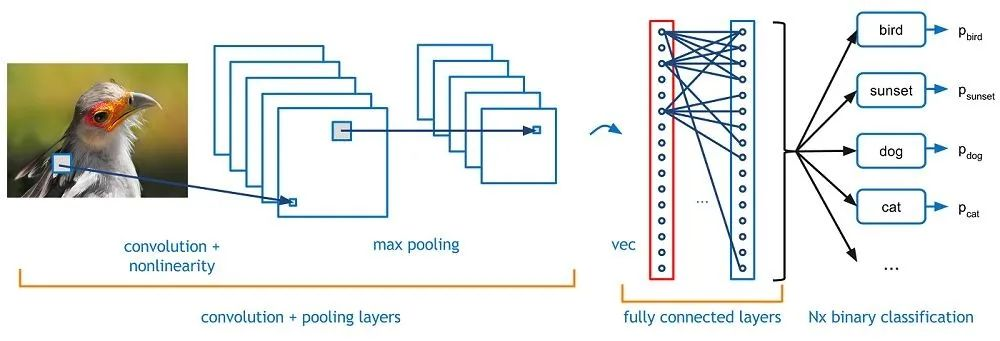

可以看到，CNN主要有三个层组成，从左至右分别为：卷积层、池化层与全连接层。

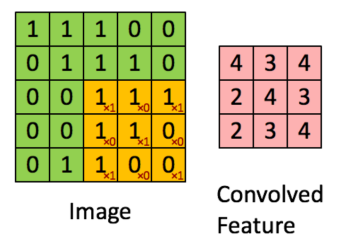

卷积层中最重要的概念是卷积核(图左橙色部分)，卷积核可以理解为是一种特征，将输入和卷积核相乘得到的结果就是输入在这个特征上的投影，这个投影可以称之为特征图。

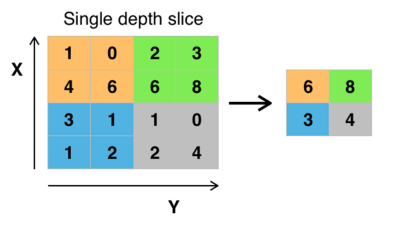

常见的池化有最大值池化(如上图所示)和平均池化两种，顾名思义就是在池化窗口内计算最大值和平均值作为池化结果。池化层的作用主要体现在：特征不变性、特征降维和减少过拟合。

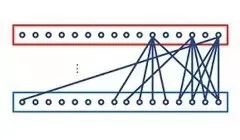

全连接层一般位于整个神经网络的最后，负责将卷积输出的二维特征图（矩阵）转换成一维向量。

对于文本分类和时间序列预测等简单任务，小型的一维卷积神经网络可以替代RNN，而且速度更快。

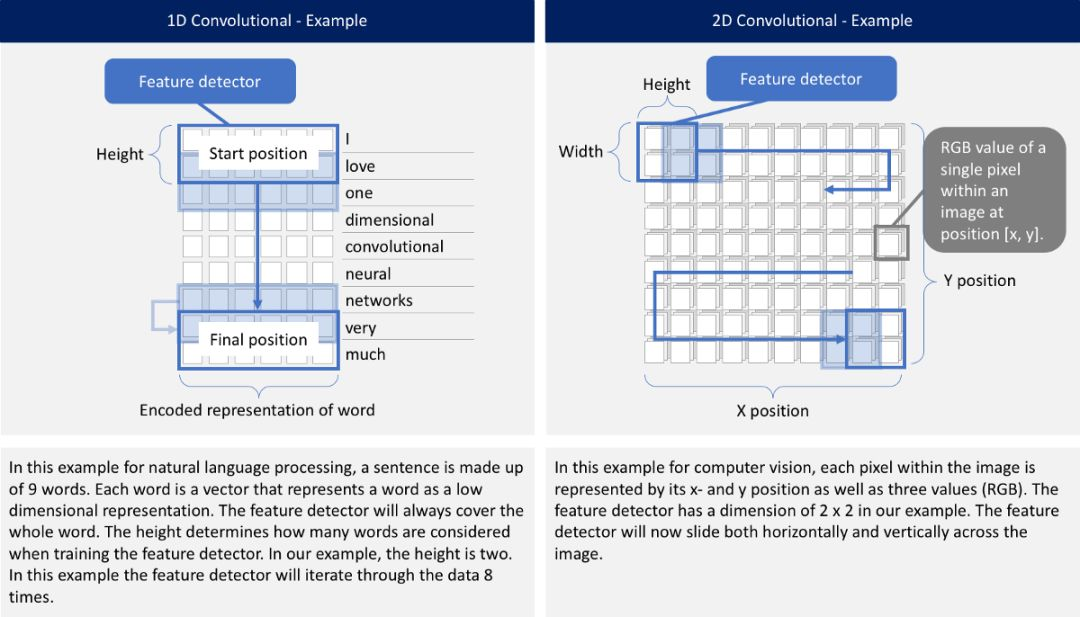

### 数据要求

**数据输入维度一般为(样本数,特征,时间步)，输出数据维度一般为(样本数,特征)。**

## LSTM-tensorflow

In [3]:
import tensorflow as tf

# 检查 GPU 是否可用
if tf.test.gpu_device_name():
    print('GPU 设备可用：', tf.test.gpu_device_name())
else:
    print("GPU 未找到，请确保已正确安装 TensorFlow-GPU 版本。")

GPU 设备可用： /device:GPU:0


### 数据准备

In [4]:
ts_data = pd.read_csv("../data/energy.csv")
ts_data = pd.DataFrame(ts_data[["load", "temp"]].values, index=pd.to_datetime(ts_data["Unnamed: 0"].values), columns=["load", "temp"])
ts_data = ts_data.asfreq(freq='H') #转换为小时频率的数据
ts_data.head()

,load,temp
2012-01-01 00:00:00,"2,698.00",32.00
2012-01-01 01:00:00,"2,558.00",32.67
2012-01-01 02:00:00,"2,444.00",30.00
2012-01-01 03:00:00,"2,402.00",31.00
2012-01-01 04:00:00,"2,403.00",32.00


对于能源预测案例，我们将2014年11月1日至2014年12月31日期间的数据划分为测试集。2014年9月1日至10月31日期间的数据划分为验证集，其他时间作为训练集。

In [5]:
valid_st_data_load = "2014-09-01 00:00:00"
test_st_data_load = "2014-11-01 00:00:00"

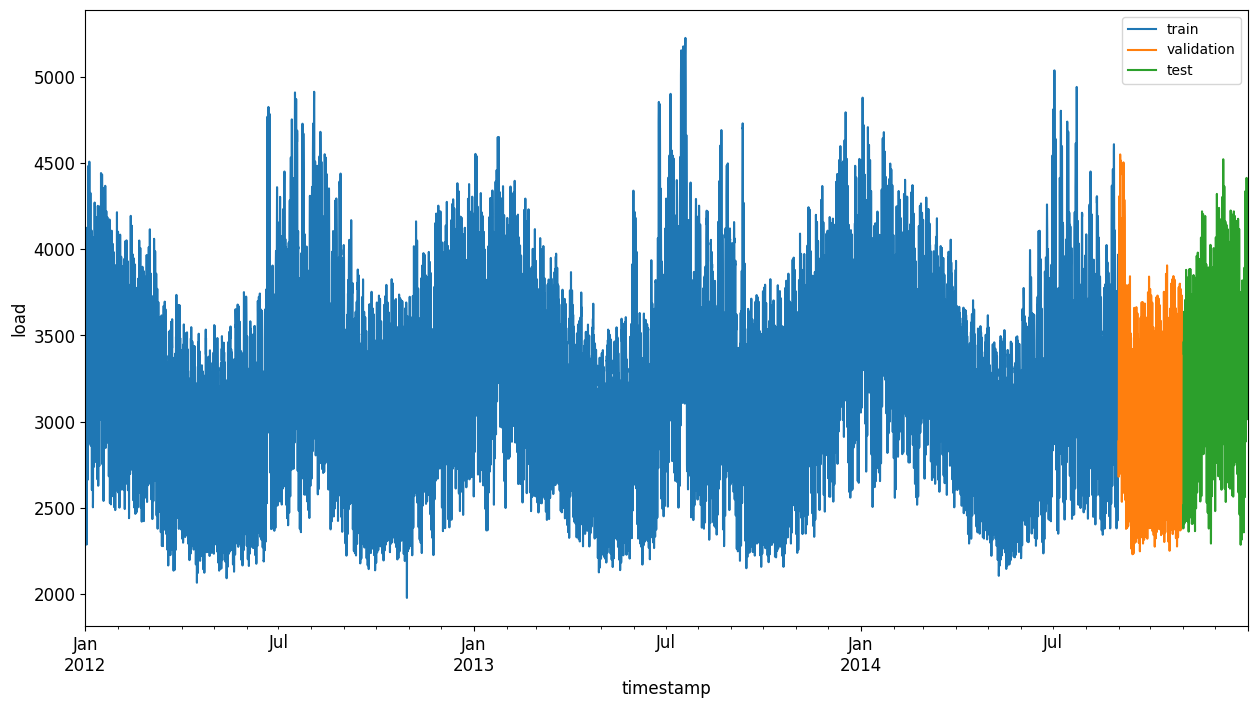

In [6]:
ts_data[ts_data.index < valid_st_data_load][["load"]].rename(columns={
    "load": "train"
}).join(
    ts_data[(ts_data.index >= valid_st_data_load)
            & (ts_data.index < test_st_data_load)][[
                "load"
            ]].rename(columns={"load": "validation"}),
    how="outer",
).join(ts_data[test_st_data_load:][["load"]].rename(columns={"load": "test"}),
       how="outer").plot(y=["train", "validation", "test"],
                         figsize=(15, 8),
                         fontsize=12)
plt.xlabel("timestamp", fontsize=12)
plt.ylabel("load", fontsize=12)
plt.show()

我们将$T$（滞后变量的数量）设置为6。这意味着每个样本的输入都是前6个小时负荷值的向量。$T=6$的选择是任意的。我们还将范围设置为1，意味着只预测下一个小时（$t+1$）的输出。

**训练集**

In [7]:
T = 6
HORIZON = 1
#训练集
train = ts_data.copy()[ts_data.index < valid_st_data_load][["load"]]
#归一化
scaler = MinMaxScaler()
train["load"] = scaler.fit_transform(train)
#时移创建滞后和前导数据
train_shifted = train.copy()
train_shifted["y_t+1"] = train_shifted["load"].shift(-1, freq="H")
for t in range(1, T + 1):
    train_shifted[str(T - t)] = train_shifted["load"].shift(T - t, freq="H")
y_col = "y_t+1"
X_cols = ["load_t-5", "load_t-4", "load_t-3", "load_t-2", "load_t-1", "load_t"]
train_shifted.columns = ["load_original"] + [y_col] + X_cols

train_shifted = train_shifted.dropna(how="any")
train_shifted.head(5)

,load_original,y_t+1,load_t-5,load_t-4,load_t-3,load_t-2,load_t-1,load_t
2012-01-01 05:00:00,0.15,0.18,0.22,0.18,0.14,0.13,0.13,0.15
2012-01-01 06:00:00,0.18,0.23,0.18,0.14,0.13,0.13,0.15,0.18
2012-01-01 07:00:00,0.23,0.29,0.14,0.13,0.13,0.15,0.18,0.23
2012-01-01 08:00:00,0.29,0.35,0.13,0.13,0.15,0.18,0.23,0.29
2012-01-01 09:00:00,0.35,0.37,0.13,0.15,0.18,0.23,0.29,0.35


**验证集**

In [8]:
T = 6
HORIZON = 1
#训练集
valid = ts_data.copy()[(ts_data.index >= valid_st_data_load) & (ts_data.index < test_st_data_load)][["load"]]
#归一化
scaler = MinMaxScaler()
valid["load"] = scaler.fit_transform(valid)
#时移创建滞后和前导数据
valid_shifted = valid.copy()
valid_shifted["y_t+1"] = valid_shifted["load"].shift(-1, freq="H")
for t in range(1, T + 1):
    valid_shifted[str(T - t)] = valid_shifted["load"].shift(T - t, freq="H")
y_col = "y_t+1"
X_cols = ["load_t-5", "load_t-4", "load_t-3", "load_t-2", "load_t-1", "load_t"]
valid_shifted.columns = ["load_original"] + [y_col] + X_cols

valid_shifted = valid_shifted.dropna(how="any")
valid_shifted.head(5)

,load_original,y_t+1,load_t-5,load_t-4,load_t-3,load_t-2,load_t-1,load_t
2014-09-01 05:00:00,0.23,0.28,0.28,0.23,0.20,0.19,0.20,0.23
2014-09-01 06:00:00,0.28,0.36,0.23,0.20,0.19,0.20,0.23,0.28
2014-09-01 07:00:00,0.36,0.51,0.20,0.19,0.20,0.23,0.28,0.36
2014-09-01 08:00:00,0.51,0.64,0.19,0.20,0.23,0.28,0.36,0.51
2014-09-01 09:00:00,0.64,0.73,0.20,0.23,0.28,0.36,0.51,0.64


**测试集**

In [9]:
T = 6
HORIZON = 1
#训练集
test = ts_data.copy()[test_st_data_load:][["load"]]
#归一化
scaler = MinMaxScaler()
test["load"] = scaler.fit_transform(test)
#时移创建滞后和前导数据
test_shifted = test.copy()
test_shifted["y_t+1"] = test_shifted["load"].shift(-1, freq="H")
for t in range(1, T + 1):
    test_shifted[str(T - t)] = test_shifted["load"].shift(T - t, freq="H")
y_col = "y_t+1"
X_cols = ["load_t-5", "load_t-4", "load_t-3", "load_t-2", "load_t-1", "load_t"]
test_shifted.columns = ["load_original"] + [y_col] + X_cols

test_shifted = test_shifted.dropna(how="any")
test_shifted.head(5)

,load_original,y_t+1,load_t-5,load_t-4,load_t-3,load_t-2,load_t-1,load_t
2014-11-01 05:00:00,0.10,0.19,0.10,0.07,0.05,0.04,0.06,0.10
2014-11-01 06:00:00,0.19,0.31,0.07,0.05,0.04,0.06,0.10,0.19
2014-11-01 07:00:00,0.31,0.40,0.05,0.04,0.06,0.10,0.19,0.31
2014-11-01 08:00:00,0.40,0.48,0.04,0.06,0.10,0.19,0.31,0.40
2014-11-01 09:00:00,0.48,0.51,0.06,0.10,0.19,0.31,0.40,0.48


![hello](../images/p19.jpg)

**转换为张量**

将$X$转换为（样本、时间步、特征）的形式，在此数据集中，我们有23370个样本，6个时间步和1个特征。

In [10]:
y_train = train_shifted[y_col].to_numpy()
X_train = train_shifted[X_cols].to_numpy()

In [11]:
y_valid = valid_shifted[y_col].to_numpy()
X_valid = valid_shifted[X_cols].to_numpy()

In [12]:
y_test = test_shifted[y_col].to_numpy()
X_test = test_shifted[X_cols].to_numpy()

将$X$输入重新构造为三维数组。

In [13]:
X_train = X_train.reshape(X_train.shape[0], T, 1)
X_train.shape

(23370, 6, 1)

In [14]:
X_valid = X_valid.reshape(X_valid.shape[0], T, 1)
X_valid.shape

(1458, 6, 1)

In [15]:
X_test = X_test.reshape(X_test.shape[0], T, 1)
X_test.shape

(1458, 6, 1)

- 单变量模型：单变量时间序列是指由按相等时间增量顺序记录的单个（标量）观测值组成的时间序列。
- 多变量模型：多变量时间序列具有多个时间相关变量，每个变量不仅取决于其过去的值，而且对其他变量也有一定的依赖性。

### 单输入单输出单步预测

![hello](../images/p23.jpg)

In [16]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.models import Model, Sequential

In [17]:
LATENT_DIM = 5 #潜在维度，隐层个数
BATCH_SIZE = 32 #批尺寸，每个小批量的样本数量
EPOCHS = 10 #周期，训练算法循环遍历所有样本的最大次数

In [18]:
model = Sequential()
model.add(GRU(LATENT_DIM, input_shape=(T, 1)))
model.add(Dense(HORIZON))

In [19]:
model.compile(optimizer="RMSprop", loss="mse")

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 5)                 120       
_________________________________________________________________
dense (Dense)                (None, 1)                 6         
Total params: 126
Trainable params: 126
Non-trainable params: 0
_________________________________________________________________


提前停止是一种正则化方法，在使用迭代方法训练机器学习模型时可避免过拟合。

In [21]:
earlystop = EarlyStopping(monitor="val_loss", min_delta=0, patience=5)

In [22]:
model_history = model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_valid, y_valid),
    callbacks=[earlystop],
    verbose=1,
)

Epoch 1/10
731/731 [==============================] - 6s 6ms/step - loss: 0.0152 - val_loss: 0.0026
Epoch 2/10
731/731 [==============================] - 4s 5ms/step - loss: 9.9254e-04 - val_loss: 0.0017
Epoch 3/10
731/731 [==============================] - 4s 5ms/step - loss: 6.6342e-04 - val_loss: 0.0011
Epoch 4/10
731/731 [==============================] - 4s 5ms/step - loss: 5.8908e-04 - val_loss: 0.0010
Epoch 5/10
731/731 [==============================] - 4s 5ms/step - loss: 5.7397e-04 - val_loss: 0.0012
Epoch 6/10
731/731 [==============================] - 4s 5ms/step - loss: 5.6827e-04 - val_loss: 0.0010
Epoch 7/10
731/731 [==============================] - 4s 5ms/step - loss: 5.6291e-04 - val_loss: 0.0012
Epoch 8/10
731/731 [==============================] - 4s 5ms/step - loss: 5.5534e-04 - val_loss: 9.9835e-04
Epoch 9/10
731/731 [==============================] - 4s 5ms/step - loss: 5.4821e-04 - val_loss: 9.9727e-04
Epoch 10/10
731/731 [==============================] - 4s 5m

In [23]:
ts_predictions = model.predict(X_test)
ts_predictions

array([[0.19],
       [0.31],
       [0.42],
       ...,
       [0.65],
       [0.55],
       [0.49]], dtype=float32)

In [24]:
#反归一化
ev_ts_data = pd.DataFrame(
    ts_predictions, columns=["t+" + str(t) for t in range(1, HORIZON + 1)]
)
ev_ts_data["timestamp"] = test_shifted.index
ev_ts_data = pd.melt(ev_ts_data, id_vars="timestamp", value_name="prediction", var_name="h")
ev_ts_data["actual"] = np.transpose(y_test).ravel()
ev_ts_data[["prediction", "actual"]] = scaler.inverse_transform(
    ev_ts_data[["prediction", "actual"]]
)
ev_ts_data.head()

,timestamp,h,prediction,actual
0,2014-11-01 05:00:00,t+1,"2,701.92","2,714.00"
1,2014-11-01 06:00:00,t+1,"2,970.07","2,970.00"
2,2014-11-01 07:00:00,t+1,"3,220.98","3,189.00"
3,2014-11-01 08:00:00,t+1,"3,336.15","3,356.00"
4,2014-11-01 09:00:00,t+1,"3,460.91","3,436.00"


In [25]:
def mape(ts_predictions, actuals):
    """Mean absolute percentage error"""
    return ((ts_predictions - actuals).abs() / actuals).mean()

In [26]:
mape(ev_ts_data["prediction"], ev_ts_data["actual"])

0.015046054993442389

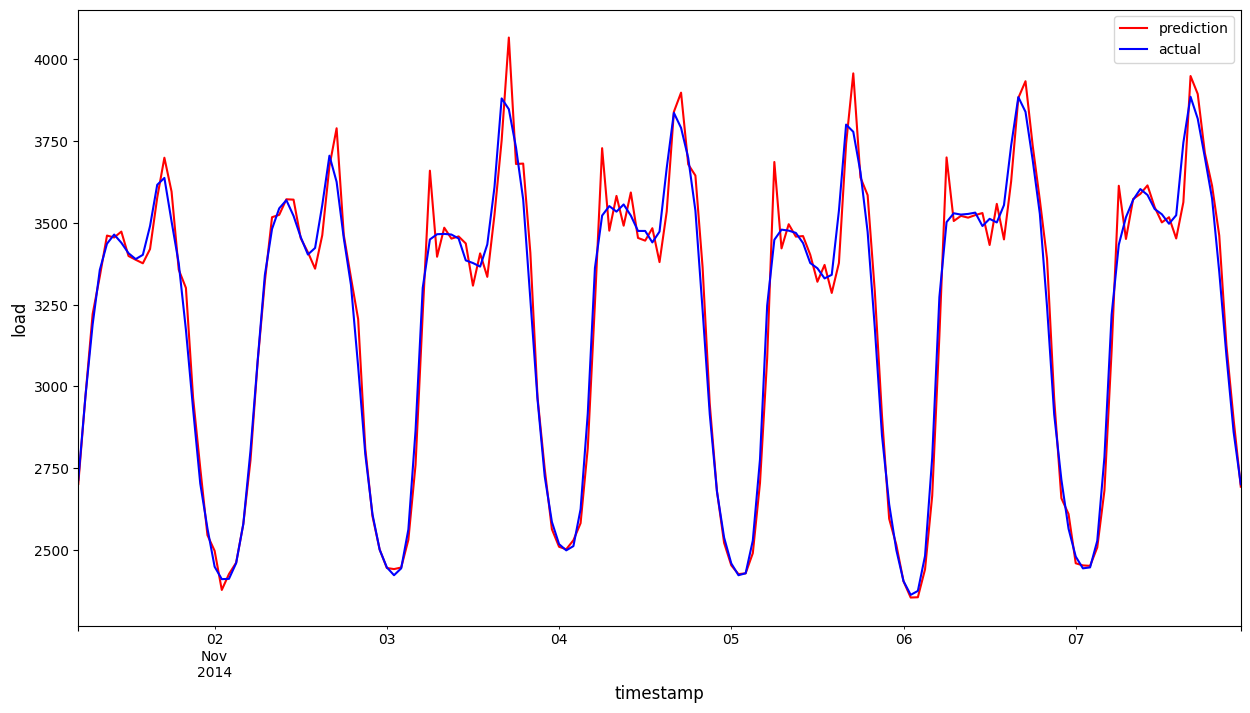

In [27]:
ev_ts_data[ev_ts_data.timestamp < "2014-11-08"].plot(
    x="timestamp", y=["prediction", "actual"], style=["r", "b"], figsize=(15, 8)
)
plt.xlabel("timestamp", fontsize=12)
plt.ylabel("load", fontsize=12)
plt.show()

### 多输入多输出单步预测

![hello](../images/p22.jpg)

In [28]:
valid_st_data_load = "2014-09-01 00:00:00"
test_st_data_load = "2014-11-01 00:00:00"

In [29]:
T = 6
HORIZON = 1

In [30]:
y_scaler = MinMaxScaler()
y_scaler.fit(train[["load"]])

MinMaxScaler()

In [31]:
train = ts_data.copy()[ts_data.index < valid_st_data_load][["load", "temp"]]
X_scaler = MinMaxScaler()
train[["load", "temp"]] = X_scaler.fit_transform(train)

#时移创建滞后和前导数据
train_shifted = train.copy()
train_shifted["y_t+1"] = train_shifted["load"].shift(-1, freq="H")
for t in range(1, T + 1):
    train_shifted["load" + str(T - t)] = train_shifted["load"].shift(T - t, freq="H")
    train_shifted["temp" + str(T - t)] = train_shifted["temp"].shift(T - t, freq="H")
y_col = "y_t+1"
X_cols_load = ["load_t-5", "load_t-4", "load_t-3", "load_t-2", "load_t-1", "load_t"]
X_cols_temp = ["temp_t-5", "temp_t-4", "temp_t-3", "temp_t-2", "temp_t-1", "temp_t"]
train_shifted.columns = ["load_original"] + ["temp_original"] + [y_col] + X_cols_load + X_cols_temp

train_shifted = train_shifted.dropna(how="any")
train_shifted.head(5)

,load_original,temp_original,y_t+1,load_t-5,load_t-4,load_t-3,load_t-2,load_t-1,load_t,temp_t-5,temp_t-4,temp_t-3,temp_t-2,temp_t-1,temp_t
2012-01-01 05:00:00,0.15,0.41,0.18,0.22,0.42,0.18,0.43,0.14,0.40,0.13,0.41,0.13,0.42,0.15,0.41
2012-01-01 06:00:00,0.18,0.40,0.23,0.18,0.43,0.14,0.40,0.13,0.41,0.13,0.42,0.15,0.41,0.18,0.40
2012-01-01 07:00:00,0.23,0.39,0.29,0.14,0.40,0.13,0.41,0.13,0.42,0.15,0.41,0.18,0.40,0.23,0.39
2012-01-01 08:00:00,0.29,0.39,0.35,0.13,0.41,0.13,0.42,0.15,0.41,0.18,0.40,0.23,0.39,0.29,0.39
2012-01-01 09:00:00,0.35,0.43,0.37,0.13,0.42,0.15,0.41,0.18,0.40,0.23,0.39,0.29,0.39,0.35,0.43


In [32]:
valid = ts_data.copy()[(ts_data.index >= valid_st_data_load) & (ts_data.index < test_st_data_load)][["load", "temp"]]
X_scaler = MinMaxScaler()
valid[["load", "temp"]] = X_scaler.fit_transform(valid)

#时移创建滞后和前导数据
valid_shifted = valid.copy()
valid_shifted["y_t+1"] = valid_shifted["load"].shift(-1, freq="H")
for t in range(1, T + 1):
    valid_shifted["load" + str(T - t)] = valid_shifted["load"].shift(T - t, freq="H")
    valid_shifted["temp" + str(T - t)] = valid_shifted["temp"].shift(T - t, freq="H")
y_col = "y_t+1"
X_cols_load = ["load_t-5", "load_t-4", "load_t-3", "load_t-2", "load_t-1", "load_t"]
X_cols_temp = ["temp_t-5", "temp_t-4", "temp_t-3", "temp_t-2", "temp_t-1", "temp_t"]
valid_shifted.columns = ["load_original"] + ["temp_original"] + [y_col] + X_cols_load + X_cols_temp

valid_shifted = valid_shifted.dropna(how="any")
valid_shifted.head(5)

,load_original,temp_original,y_t+1,load_t-5,load_t-4,load_t-3,load_t-2,load_t-1,load_t,temp_t-5,temp_t-4,temp_t-3,temp_t-2,temp_t-1,temp_t
2014-09-01 05:00:00,0.23,0.67,0.28,0.28,0.73,0.23,0.71,0.20,0.69,0.19,0.67,0.20,0.67,0.23,0.67
2014-09-01 06:00:00,0.28,0.66,0.36,0.23,0.71,0.20,0.69,0.19,0.67,0.20,0.67,0.23,0.67,0.28,0.66
2014-09-01 07:00:00,0.36,0.66,0.51,0.20,0.69,0.19,0.67,0.20,0.67,0.23,0.67,0.28,0.66,0.36,0.66
2014-09-01 08:00:00,0.51,0.69,0.64,0.19,0.67,0.20,0.67,0.23,0.67,0.28,0.66,0.36,0.66,0.51,0.69
2014-09-01 09:00:00,0.64,0.76,0.73,0.20,0.67,0.23,0.67,0.28,0.66,0.36,0.66,0.51,0.69,0.64,0.76


In [33]:
test = ts_data.copy()[test_st_data_load:][["load", "temp"]]
X_scaler = MinMaxScaler()
test[["load", "temp"]] = X_scaler.fit_transform(test)

#时移创建滞后和前导数据
test_shifted = test.copy()
test_shifted["y_t+1"] = test_shifted["load"].shift(-1, freq="H")
for t in range(1, T + 1):
    test_shifted["load" + str(T - t)] = test_shifted["load"].shift(T - t, freq="H")
    test_shifted["temp" + str(T - t)] = test_shifted["temp"].shift(T - t, freq="H")
y_col = "y_t+1"
X_cols_load = ["load_t-5", "load_t-4", "load_t-3", "load_t-2", "load_t-1", "load_t"]
X_cols_temp = ["temp_t-5", "temp_t-4", "temp_t-3", "temp_t-2", "temp_t-1", "temp_t"]
test_shifted.columns = ["load_original"] + ["temp_original"] + [y_col] + X_cols_load + X_cols_temp

test_shifted = test_shifted.dropna(how="any")
test_shifted.head(5)

,load_original,temp_original,y_t+1,load_t-5,load_t-4,load_t-3,load_t-2,load_t-1,load_t,temp_t-5,temp_t-4,temp_t-3,temp_t-2,temp_t-1,temp_t
2014-11-01 05:00:00,0.10,0.52,0.19,0.10,0.54,0.07,0.52,0.05,0.50,0.04,0.50,0.06,0.50,0.10,0.52
2014-11-01 06:00:00,0.19,0.52,0.31,0.07,0.52,0.05,0.50,0.04,0.50,0.06,0.50,0.10,0.52,0.19,0.52
2014-11-01 07:00:00,0.31,0.54,0.40,0.05,0.50,0.04,0.50,0.06,0.50,0.10,0.52,0.19,0.52,0.31,0.54
2014-11-01 08:00:00,0.40,0.55,0.48,0.04,0.50,0.06,0.50,0.10,0.52,0.19,0.52,0.31,0.54,0.40,0.55
2014-11-01 09:00:00,0.48,0.60,0.51,0.06,0.50,0.10,0.52,0.19,0.52,0.31,0.54,0.40,0.55,0.48,0.60


In [34]:
y_train = train_shifted[y_col].to_numpy()
X_train = train_shifted[X_cols_load+X_cols_temp].to_numpy()

In [35]:
y_valid = valid_shifted[y_col].to_numpy()
X_valid = valid_shifted[X_cols_load+X_cols_temp].to_numpy()

In [36]:
y_test = test_shifted[y_col].to_numpy()
X_test = test_shifted[X_cols_load+X_cols_temp].to_numpy()

In [37]:
X_train = X_train.reshape(X_train.shape[0], T, 2)
X_train.shape

(23370, 6, 2)

In [38]:
X_valid = X_valid.reshape(X_valid.shape[0], T, 2)
X_valid.shape

(1458, 6, 2)

In [39]:
X_test = X_test.reshape(X_test.shape[0], T, 2)
X_test.shape

(1458, 6, 2)

In [40]:
LATENT_DIM = 5
BATCH_SIZE = 32
EPOCHS = 50

model = Sequential()
model.add(GRU(LATENT_DIM, input_shape=(T, 2)))
model.add(Dense(HORIZON))

In [41]:
model.compile(optimizer="RMSprop", loss="mse")

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 5)                 135       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6         
Total params: 141
Trainable params: 141
Non-trainable params: 0
_________________________________________________________________


In [42]:
earlystop = EarlyStopping(monitor="val_loss", min_delta=0, patience=5)

In [43]:
model_history = model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_valid, y_valid),
    callbacks=[earlystop],
    verbose=1,
)

Epoch 1/50
731/731 [==============================] - 6s 6ms/step - loss: 0.0107 - val_loss: 0.0026
Epoch 2/50
731/731 [==============================] - 4s 5ms/step - loss: 0.0010 - val_loss: 0.0018
Epoch 3/50
731/731 [==============================] - 4s 5ms/step - loss: 7.6958e-04 - val_loss: 0.0013
Epoch 4/50
731/731 [==============================] - 4s 5ms/step - loss: 6.6796e-04 - val_loss: 0.0013
Epoch 5/50
731/731 [==============================] - 4s 5ms/step - loss: 6.2499e-04 - val_loss: 0.0012
Epoch 6/50
731/731 [==============================] - 4s 5ms/step - loss: 6.0061e-04 - val_loss: 9.8969e-04
Epoch 7/50
731/731 [==============================] - 4s 5ms/step - loss: 5.8179e-04 - val_loss: 0.0011
Epoch 8/50
731/731 [==============================] - 4s 5ms/step - loss: 5.6851e-04 - val_loss: 9.3250e-04
Epoch 9/50
731/731 [==============================] - 4s 6ms/step - loss: 5.5898e-04 - val_loss: 9.3194e-04
Epoch 10/50
731/731 [==============================] - 4s 6m

In [44]:
ts_predictions = model.predict(X_test)
ts_predictions

array([[0.19],
       [0.3 ],
       [0.41],
       ...,
       [0.62],
       [0.53],
       [0.48]], dtype=float32)

In [45]:
ev_ts_data = pd.DataFrame(
    ts_predictions, columns=["t+" + str(t) for t in range(1, HORIZON + 1)]
)
ev_ts_data["timestamp"] = test_shifted.index
ev_ts_data = pd.melt(ev_ts_data, id_vars="timestamp", value_name="prediction", var_name="h")
ev_ts_data["actual"] = np.transpose(y_test).ravel()
ev_ts_data[["prediction", "actual"]] = scaler.inverse_transform(
    ev_ts_data[["prediction", "actual"]]
)
ev_ts_data.head()

,timestamp,h,prediction,actual
0,2014-11-01 05:00:00,t+1,"2,708.91","2,714.00"
1,2014-11-01 06:00:00,t+1,"2,958.44","2,970.00"
2,2014-11-01 07:00:00,t+1,"3,199.14","3,189.00"
3,2014-11-01 08:00:00,t+1,"3,313.76","3,356.00"
4,2014-11-01 09:00:00,t+1,"3,463.72","3,436.00"


In [46]:
def mape(ts_predictions, actuals):
    """Mean absolute percentage error"""
    return ((ts_predictions - actuals).abs() / actuals).mean()

In [47]:
mape(ev_ts_data["prediction"], ev_ts_data["actual"])

0.01444054625475646

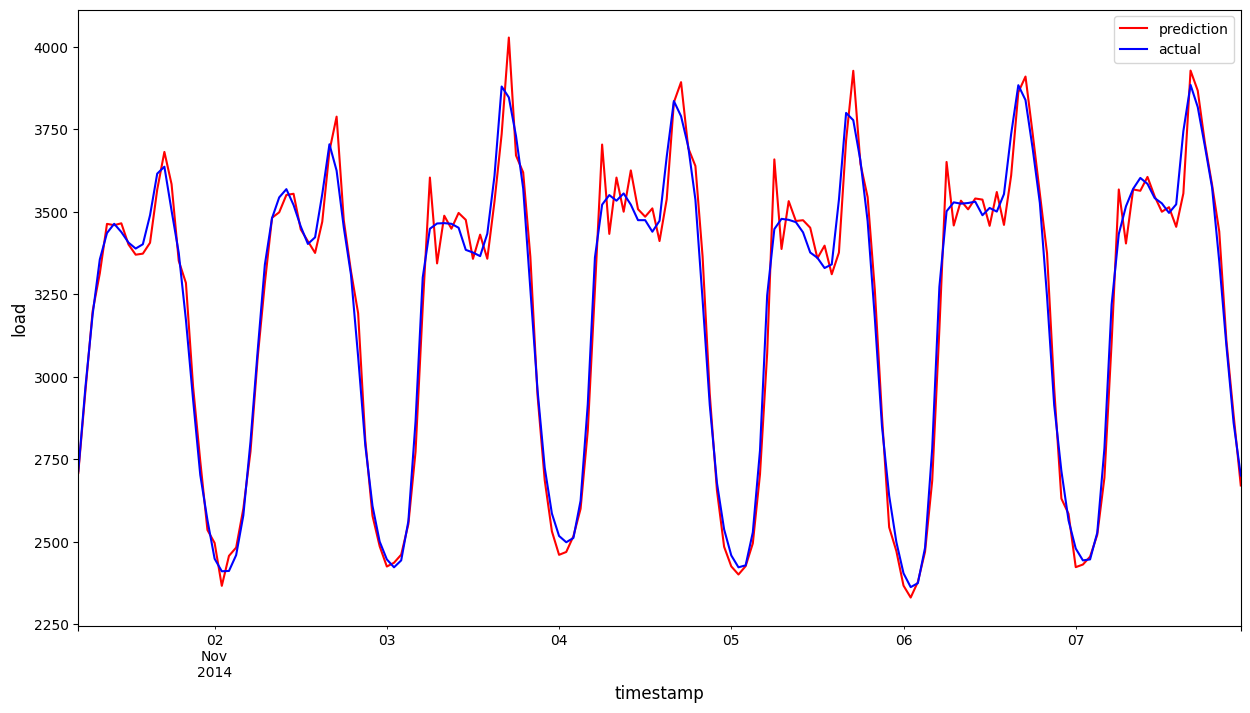

In [48]:
ev_ts_data[ev_ts_data.timestamp < "2014-11-08"].plot(
    x="timestamp", y=["prediction", "actual"], style=["r", "b"], figsize=(15, 8)
)
plt.xlabel("timestamp", fontsize=12)
plt.ylabel("load", fontsize=12)
plt.show()